In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import pandas as pd

In [2]:
df=pd.DataFrame()
N=100
for i in range(N):
    df.loc[i,'x']=random.random()
    df.loc[i,'y']=random.random()
    df.loc[i,'p']=-10+20*random.random()

In [3]:
df

,x,y,p
0,0.171564,0.300562,-6.256554
1,0.678612,0.886570,-3.156241
2,0.192954,0.122174,-3.945216
3,0.699615,0.869071,-4.305496
4,0.532126,0.821394,-4.698415
...,...,...,...
95,0.090894,0.350403,-1.803974
96,0.499692,0.108373,6.756228
97,0.352715,0.137318,-5.815575
98,0.521858,0.612422,-0.852587


In [4]:
M=10
n=len(df)
model = AbstractModel()
model.N =Param(mutable=True, default=n) 
model.i = RangeSet(1,model.N)
model.xL = Var(bounds=(0,1), within=Reals)
model.yL = Var(bounds=(0,1), within=Reals)
model.xU = Var(bounds=(0,1), within=Reals)
model.yU = Var(bounds=(0,1), within=Reals)

model.Ux = Var(model.i,bounds=(0,1), within=Binary)
model.Uxx = Var(model.i,bounds=(0,1), within=Binary)
model.Uyy = Var(model.i,bounds=(0,1), within=Binary)
model.Uy = Var(model.i,bounds=(0,1), within=Binary)

model.U = Var(model.i,bounds=(0,1), within=Reals)


def initx(model,i):
    return df.loc[i-1,'x']
model.X = Param(model.i,initialize=initx, mutable=True)

def inity(model,i):
    return df.loc[i-1,'y']
model.Y = Param(model.i,initialize=inity,  mutable=True)

def rule_C1(model):
    return model.xL<=model.xU  
model.C1   = Constraint(rule=rule_C1)

def rule_C2(model):
    return model.yL<=model.yU  
model.C2   = Constraint(rule=rule_C2)

def rule_C3(model,i):
    return model.xU+M*(1-model.Ux[i]) >= model.X[i]
model.C3   = Constraint(model.i,rule=rule_C3)

def rule_C4(model,i):
    return model.xU-M*(model.Ux[i]) <= model.X[i]
model.C4   = Constraint(model.i,rule=rule_C4)

def rule_C3A(model,i):
    return  model.X[i]+M*(1-model.Uxx[i]) >=model.xL
model.C3A   = Constraint(model.i,rule=rule_C3A)

def rule_C4A(model,i):
    return model.X[i] -M*(model.Uxx[i]) <= model.xL
model.C4A   = Constraint(model.i,rule=rule_C4A)

def rule_C6A(model,i):
    return model.yU+M*(1-model.Uy[i]) >= model.Y[i]
model.C6A  = Constraint(model.i,rule=rule_C6A)

def rule_C6B(model,i):
    return model.yU-M*(model.Uy[i]) <= model.Y[i]
model.C6B   = Constraint(model.i,rule=rule_C6B)

def rule_C6C(model,i):
    return  model.Y[i]+M*(1-model.Uyy[i]) >=model.yL
model.C6C   = Constraint(model.i,rule=rule_C6C)

def rule_C6D(model,i):
    return model.Y[i] -M*(model.Uyy[i]) <= model.yL
model.C6D   = Constraint(model.i,rule=rule_C6D)

def rule_C5A(model,i):
    return  model.U[i]<=model.Uy[i] 
model.C5A   = Constraint(model.i,rule=rule_C5A)
def rule_C5B(model,i):
    return  model.U[i]<=model.Ux[i] 
model.C5B   = Constraint(model.i,rule=rule_C5B)

def rule_C5D(model,i):
    return  model.U[i]<=model.Uxx[i] 
model.C5D   = Constraint(model.i,rule=rule_C5D)

def rule_C5E(model,i):
    return  model.U[i]<=model.Uyy[i] 
model.C5E   = Constraint(model.i,rule=rule_C5E)


def rule_C5C(model,i):
    return  model.U[i]>=model.Ux[i]+model.Uxx[i]+model.Uy[i]+model.Uyy[i]-3 
model.C5C   = Constraint(model.i,rule=rule_C5C)

def rule_OF(model):
    return sum(model.U[i]*df.loc[i-1,'p'] for i in model.i)

model.obj = Objective(rule=rule_OF, sense=maximize)

opt = SolverFactory('glpk')
instance = model.create_instance()


In [5]:
results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.obj))
print ("The solver returned a status of:"+str(results.solver.status))
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print (str(results.solver))
        

OF=  39.546265614113196
The solver returned a status of:ok
this is feasible and optimal


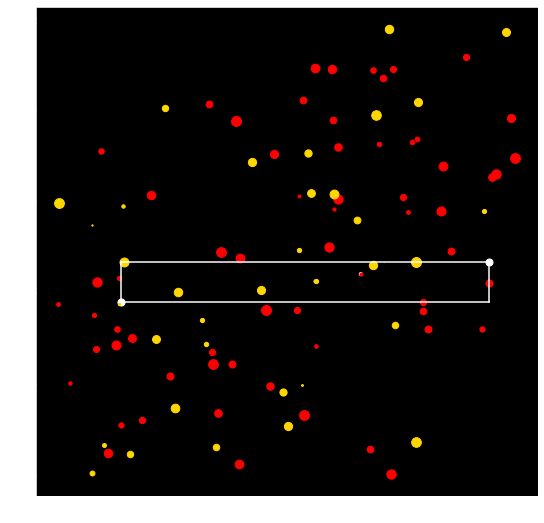

In [6]:
fig = plt.figure(figsize=(9,9))
plt.style.use('dark_background')

shift=1
plt.scatter(value(instance.xL),value(instance.yL),label=str(i), s=50, c='w')
plt.scatter(value(instance.xU),value(instance.yU),label=str(i), s=50, c='w')
plt.plot([value(instance.xL),value(instance.xU)], [value(instance.yU),value(instance.yU)] , c='w')
plt.plot([value(instance.xL),value(instance.xU)], [value(instance.yL),value(instance.yL)] , c='w')
plt.plot([value(instance.xL),value(instance.xL)], [value(instance.yL),value(instance.yU)] , c='w')
plt.plot([value(instance.xU),value(instance.xU)], [value(instance.yL),value(instance.yU)] , c='w')
for i in range(1,n):
    if value(instance.U[i])>0:
        plt.scatter(value(instance.X[i]),value(instance.Y[i]), s=10,facecolors='none', edgecolors='w')
    if df.loc[i-1,'p']>0:
        plt.scatter(value(instance.X[i]),value(instance.Y[i]), s=0.1*n*abs(df.loc[i-1,'p']), c='gold')
    else:
        plt.scatter(value(instance.X[i]),value(instance.Y[i]), s=0.1*n*abs(df.loc[i-1,'p']), c='r')
    plt.xticks(fontsize=12,fontweight='bold')
    plt.yticks(fontsize=12,fontweight='bold')